In [1]:
import random

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

plt.style.use('ggplot')

In [2]:
mlflow.login()

D:\Projects\corn-disease\.venv\Lib\site-packages\databricks\sdk\service\jobs.py:60: SyntaxWarning: invalid escape sequence '\.'
  """The sequence number of this run attempt for a triggered job run. The initial attempt of a run
D:\Projects\corn-disease\.venv\Lib\site-packages\databricks\sdk\service\jobs.py:2571: SyntaxWarning: invalid escape sequence '\.'
  """The sequence number of this run attempt for a triggered job run. The initial attempt of a run
D:\Projects\corn-disease\.venv\Lib\site-packages\databricks\sdk\service\jobs.py:3417: SyntaxWarning: invalid escape sequence '\.'
  """The sequence number of this run attempt for a triggered job run. The initial attempt of a run
2024/07/11 21:35:33 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [3]:
target = 'labels'
class_names = ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']

In [54]:
train = pl.read_parquet('data/train_data.parquet')
val = pl.read_parquet('data/validation_data.parquet')
test = pl.read_parquet('data/test_data.parquet')

In [55]:
X_train, y_train = train.drop(target), train[target]
X_val, y_val = val.drop(target), val[target]
X_test, y_test = test.drop(target), test[target]

In [6]:
mlflow.set_experiment('/corn-disease-hybrid-ml')

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3077886415753277', creation_time=1720696334031, experiment_id='3077886415753277', last_update_time=1720702997744, lifecycle_stage='active', name='/corn-disease-hybrid-ml', tags={'mlflow.experiment.sourceName': '/corn-disease-hybrid-ml',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'vsefareez@student.unmul.ac.id',
 'mlflow.ownerId': '3913636749821090'}>

In [56]:
# Custom cross-validation generator that only uses the training and validation sets
class PredefinedSplit:
    def __init__(self, test_fold):
        self.test_fold = test_fold

    def split(self, X, y=None, groups=None):
        train_indices = np.where(self.test_fold == -1)[0]
        test_indices = np.where(self.test_fold == 0)[0]
        yield train_indices, test_indices

    def get_n_splits(self, X, y=None, groups=None):
        return 1

In [57]:
def get_feature_importance(model):
    model.fit(X_train, y_train)
    return permutation_importance(model, X_val, y_val, random_state=42, n_jobs=3)


def filter_feature(perm, X):
    # take top 5% of the important feature from df
    top_importances_subset = 0.05
    top_importances = int(X.shape[1] * top_importances_subset)
    indices = np.argsort(perm.importances_mean)[::-1][:top_importances]
    return X.select([X.columns[i] for i in indices])

In [58]:
def feature_selection(estimator):
    with mlflow.start_run(
            run_name=f'fs_{estimator.__class__.__name__}_{random.randint(0, 1000)}',
            tags={'feature_selection': 'true'}):
        perm = get_feature_importance(estimator)
        train_filtered = filter_feature(perm, X_train)
        val_filtered = filter_feature(perm, X_val)
        test_filtered = filter_feature(perm, X_test)
        mlflow.log_params(estimator.get_params())

        train_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet')
        val_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet')
        test_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet')

        mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet',
                            'train_filtered.parquet')
        mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet', 'val_filtered.parquet')
        mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet', 'test_filtered.parquet')
    return train_filtered, val_filtered, test_filtered

In [59]:
def log_cv_results(cv_results, estimator_name):
    cv_results_df = pl.DataFrame(cv_results, strict=False)
    param_col = [pl.col(col).map_elements(lambda x: x) for col in cv_results_df.columns if col.startswith('param_')]
    cv_results_df.select(
        pl.col('split0_test_score'),
        pl.col('rank_test_score'),
        *param_col
    ).write_csv(f'.artifacts/{estimator_name}_cv_results.csv')
    mlflow.log_artifact(f'.artifacts/{estimator_name}_cv_results.csv', 'cv_results')

In [60]:
def tune_hyperparameter(estimator, param_grid, X_train_filtered, X_val_filtered, X_test_filtered):
    test_fold = np.concatenate([np.full(len(X_train_filtered), -1), np.full(len(X_val_filtered), 0)])
    X_combined = np.concatenate((X_train_filtered, X_val_filtered), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)

    with mlflow.start_run(
            run_name=f'tune_{estimator.__class__.__name__}_{random.randint(0, 1000)}',
            tags={'tuning': 'true'}):
        random_search = RandomizedSearchCV(estimator,
                                           param_grid,
                                           scoring='accuracy',
                                           n_iter=5,
                                           n_jobs=3,
                                           verbose=2,
                                           cv=PredefinedSplit(test_fold))
        random_search.fit(X_combined, y_combined)
        mlflow.log_params(random_search.best_params_)
        mlflow.log_param('scoring', 'accuracy')
        mlflow.log_metric('best_score', random_search.best_score_)
        log_cv_results(random_search.cv_results_, estimator.__class__.__name__)
        mlflow.sklearn.log_model(random_search.best_estimator_, 'best_model')

        accuracy, recall, precision, confusion = evaluate_model(random_search.best_estimator_, X_test_filtered)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)
    return random_search.best_estimator_

In [61]:
def evaluate_model(estimator, X_test):
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    confusion = confusion_matrix(y_test, y_pred, normalize='true')
    return accuracy, recall, precision, confusion

In [63]:
def log_cm(confusion):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 10
    fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
    sns.heatmap(confusion, annot=True, fmt='.1%', cmap='Blues',
                ax=ax, annot_kws={"fontsize": 11},
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    mlflow.log_figure(fig, 'confusion_matrix.png')
    plt.show()
    plt.close(fig)

In [64]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(random_state=42),
                         algorithm='SAMME',
                         random_state=42)
bdt_X = feature_selection(bdt)

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 5 candidates, totalling 5 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
2024/07/11 22:29:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2024/07/11 22:29:07 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for 

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


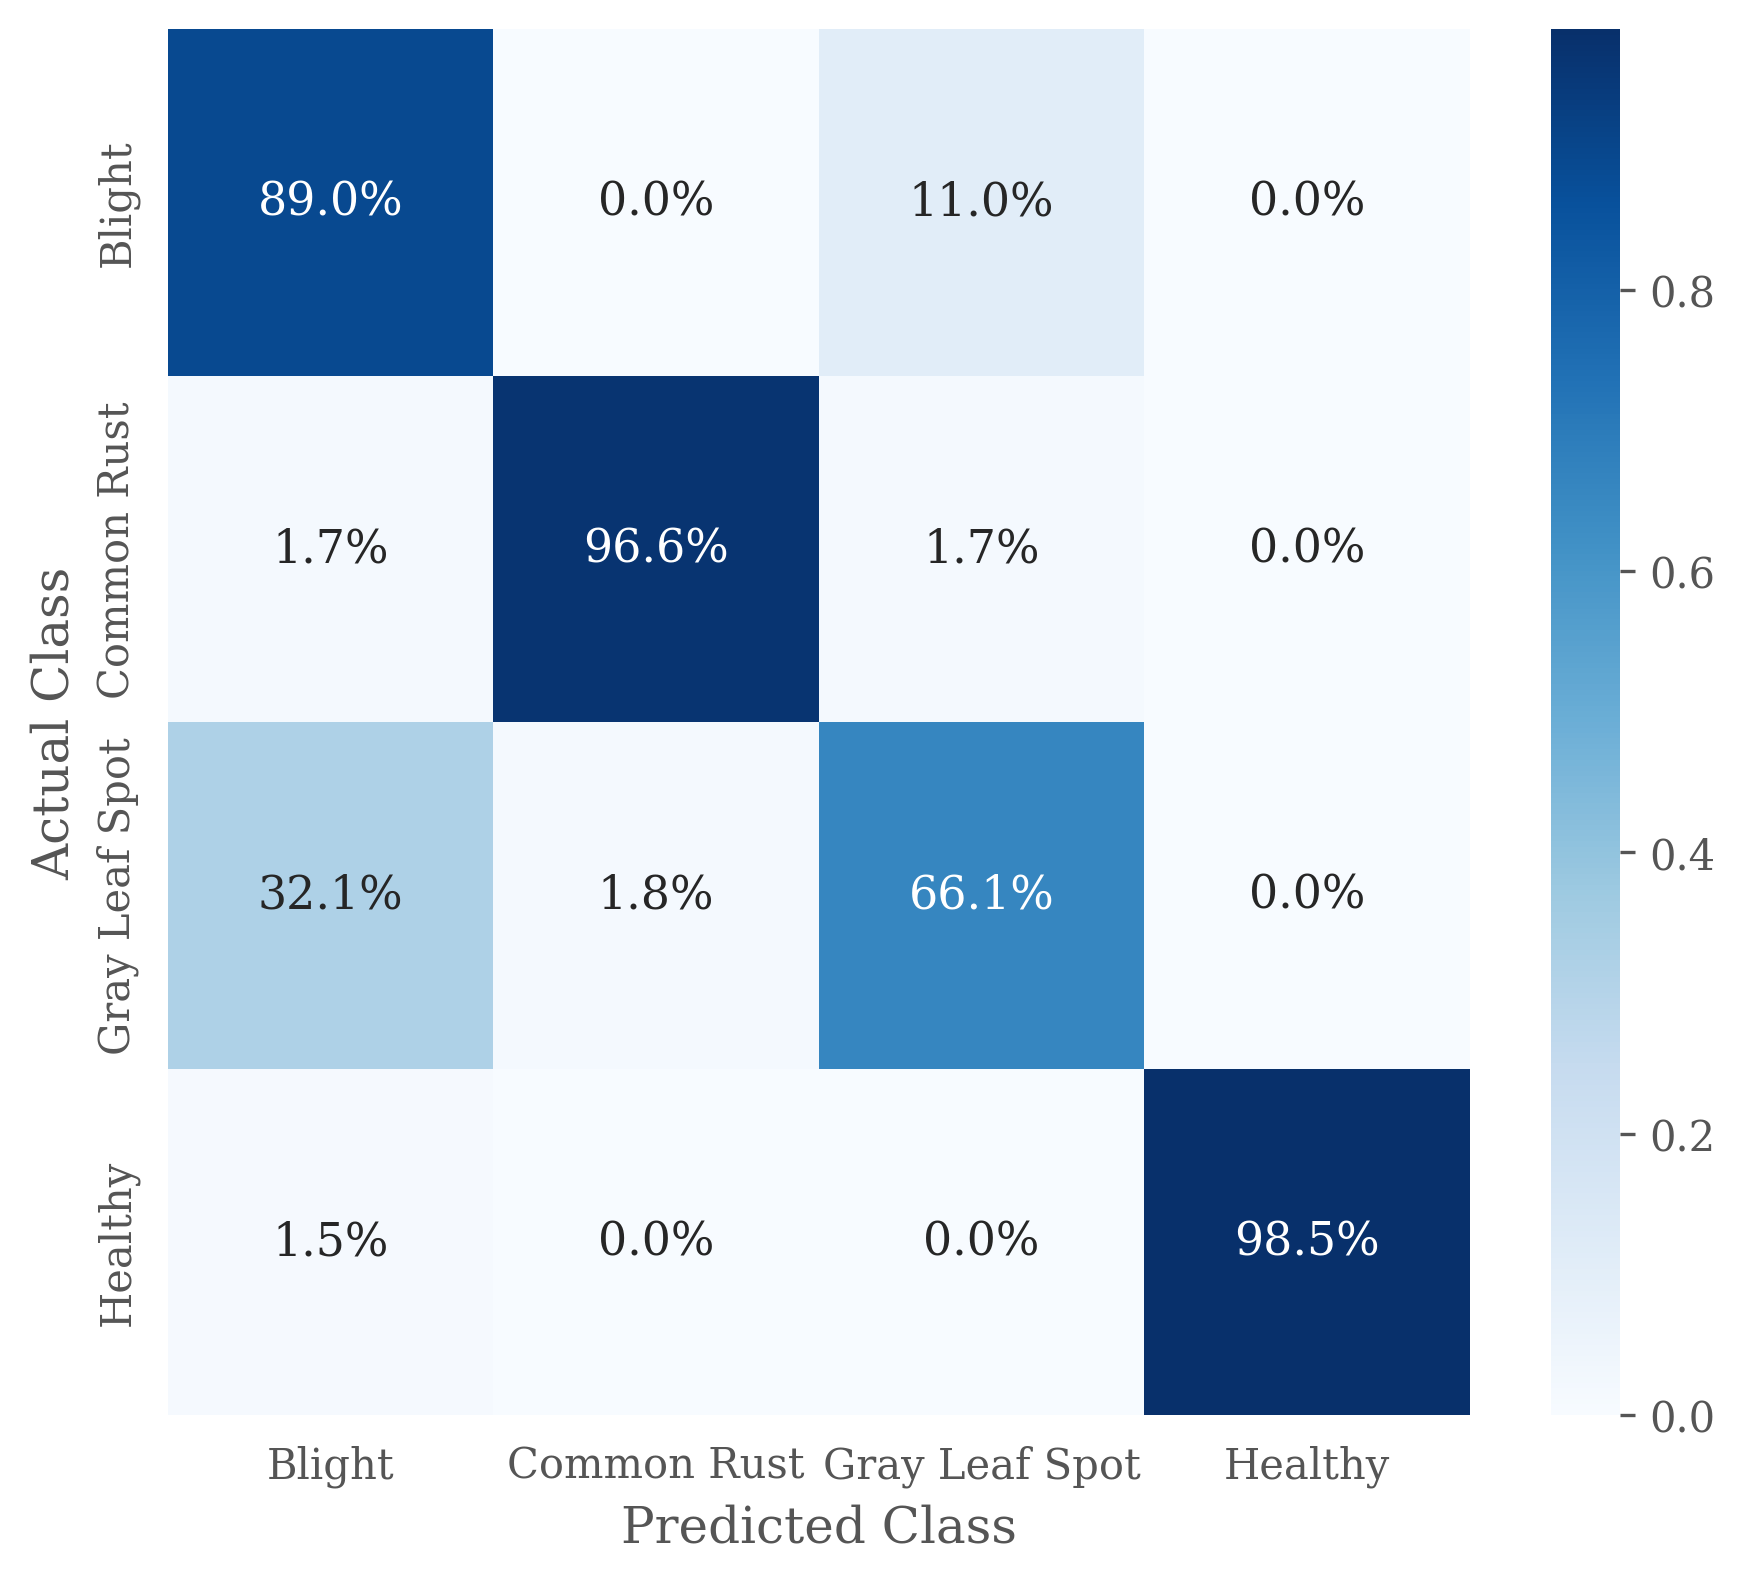

In [65]:
best_bdt = tune_hyperparameter(
    bdt,
    {
        'n_estimators': [20, 100, 500, 50],
        'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
        'estimator__min_samples_leaf': [1, 10, 50],
        'estimator__max_leaf_nodes': [2, 8, 32, 128, None]
    },
    bdt_X[0], bdt_X[1], bdt_X[2]
)

In [66]:
rf = RandomForestClassifier(random_state=42)
rf_X = feature_selection(rf)

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 5 candidates, totalling 5 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
2024/07/11 22:31:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2024/07/11 22:31:12 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.14.2/models.html#set-s

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


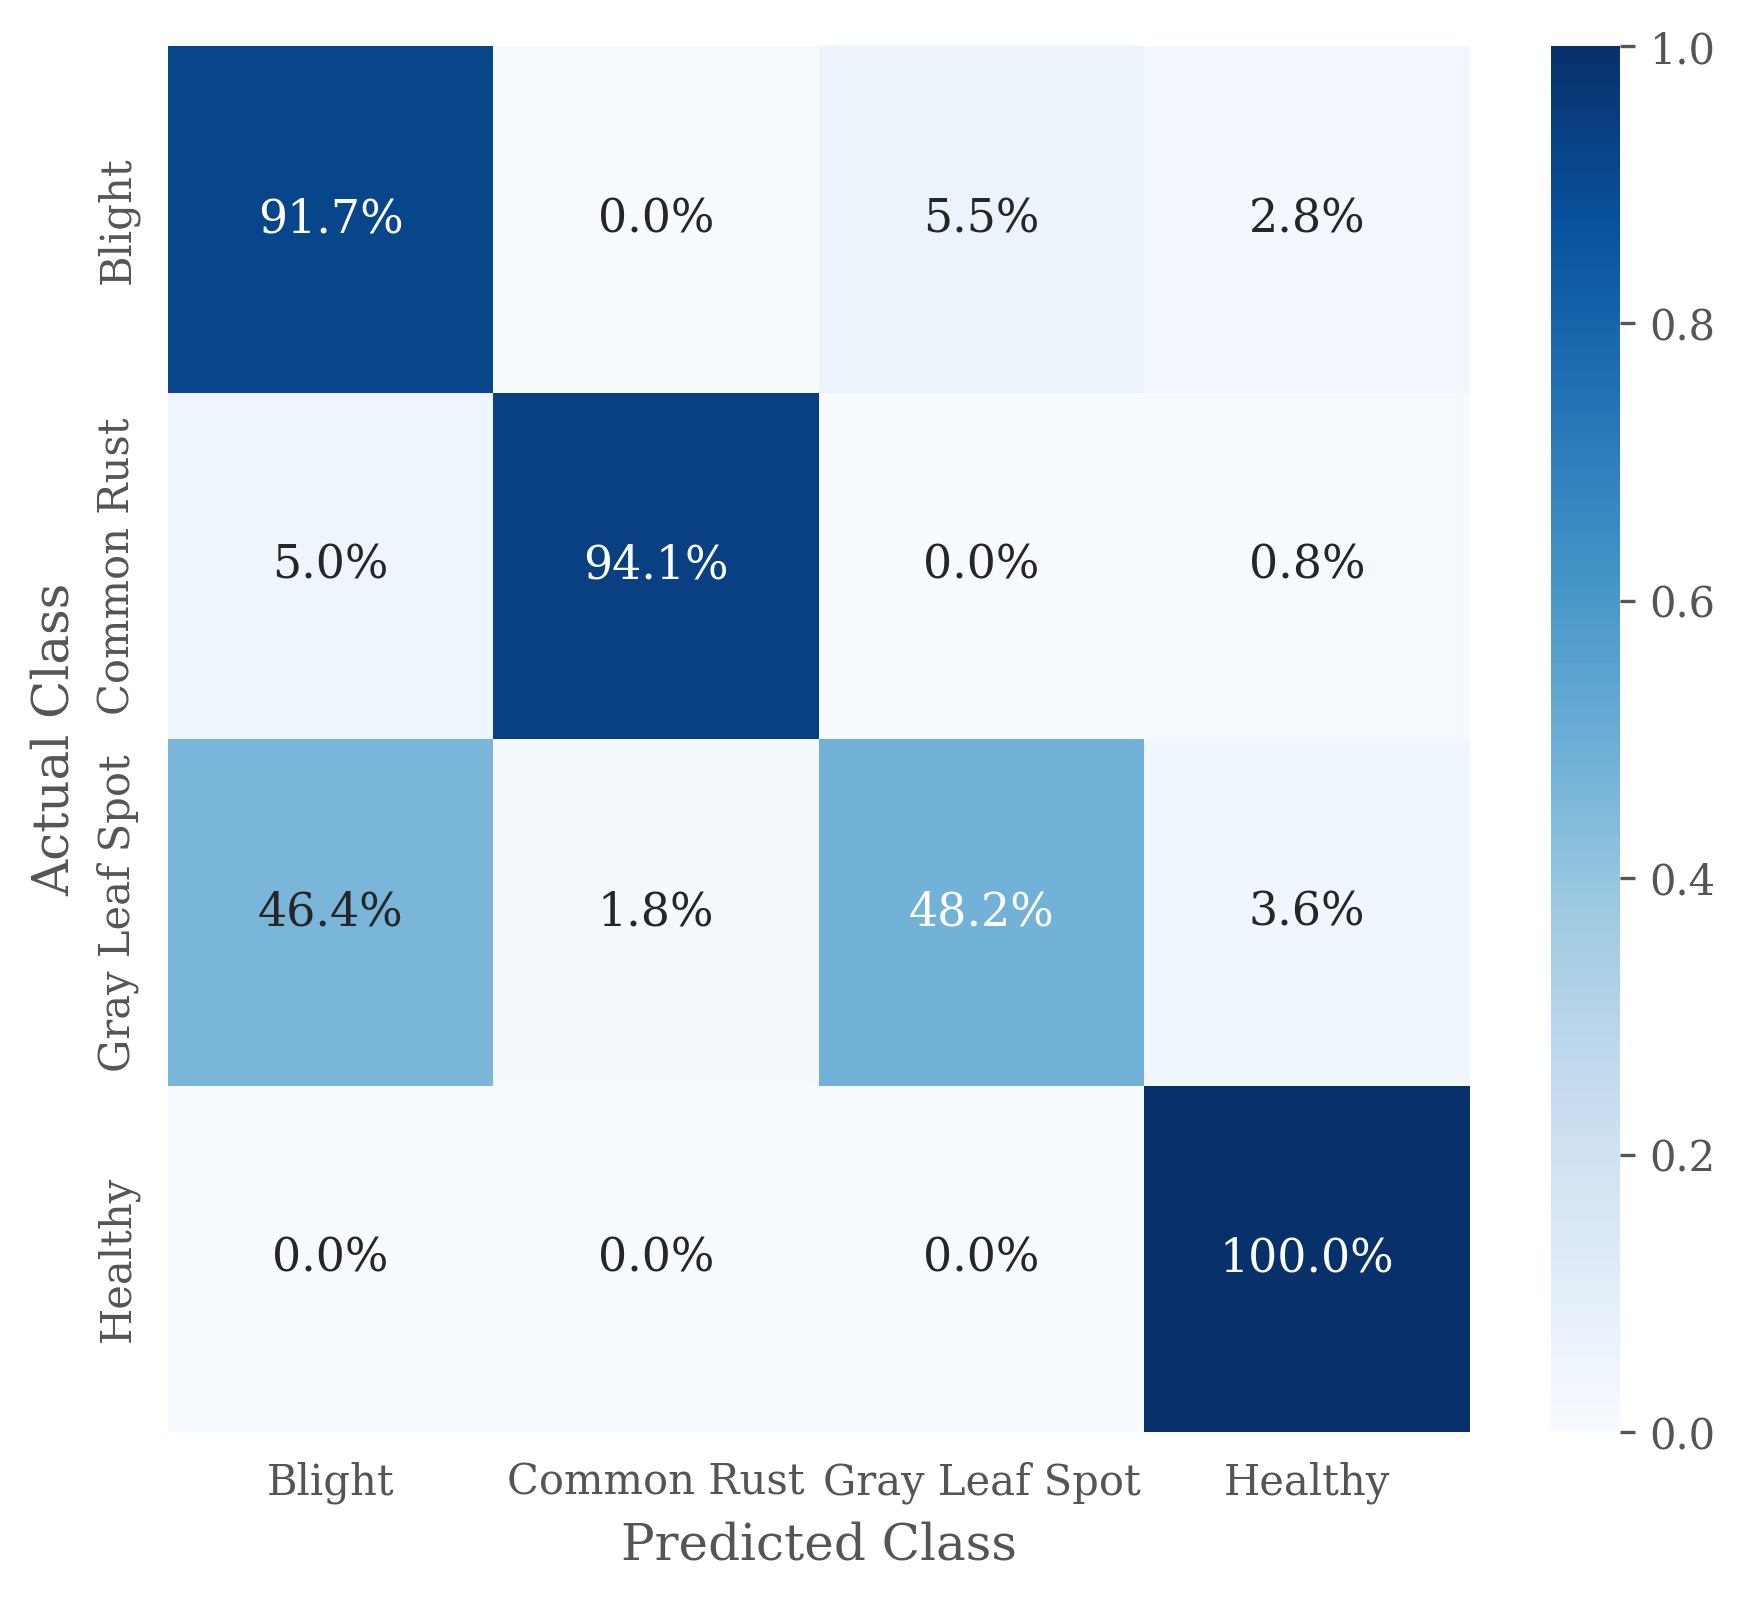

In [67]:
best_rf = tune_hyperparameter(
    rf,
    {
        'max_depth': [1, 16, 64],
        'n_estimators': [1, 8, 32],
        'min_samples_leaf': [1, 4, 16],
    },
    rf_X[0], rf_X[1], rf_X[2]
)

In [68]:
lr = LogisticRegression(random_state=42)
lr_X = feature_selection(lr)

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 5 candidates, totalling 5 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
2024/07/11 22:31:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2024/07/11 22:31:37 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.14.2/models.html#set-s

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


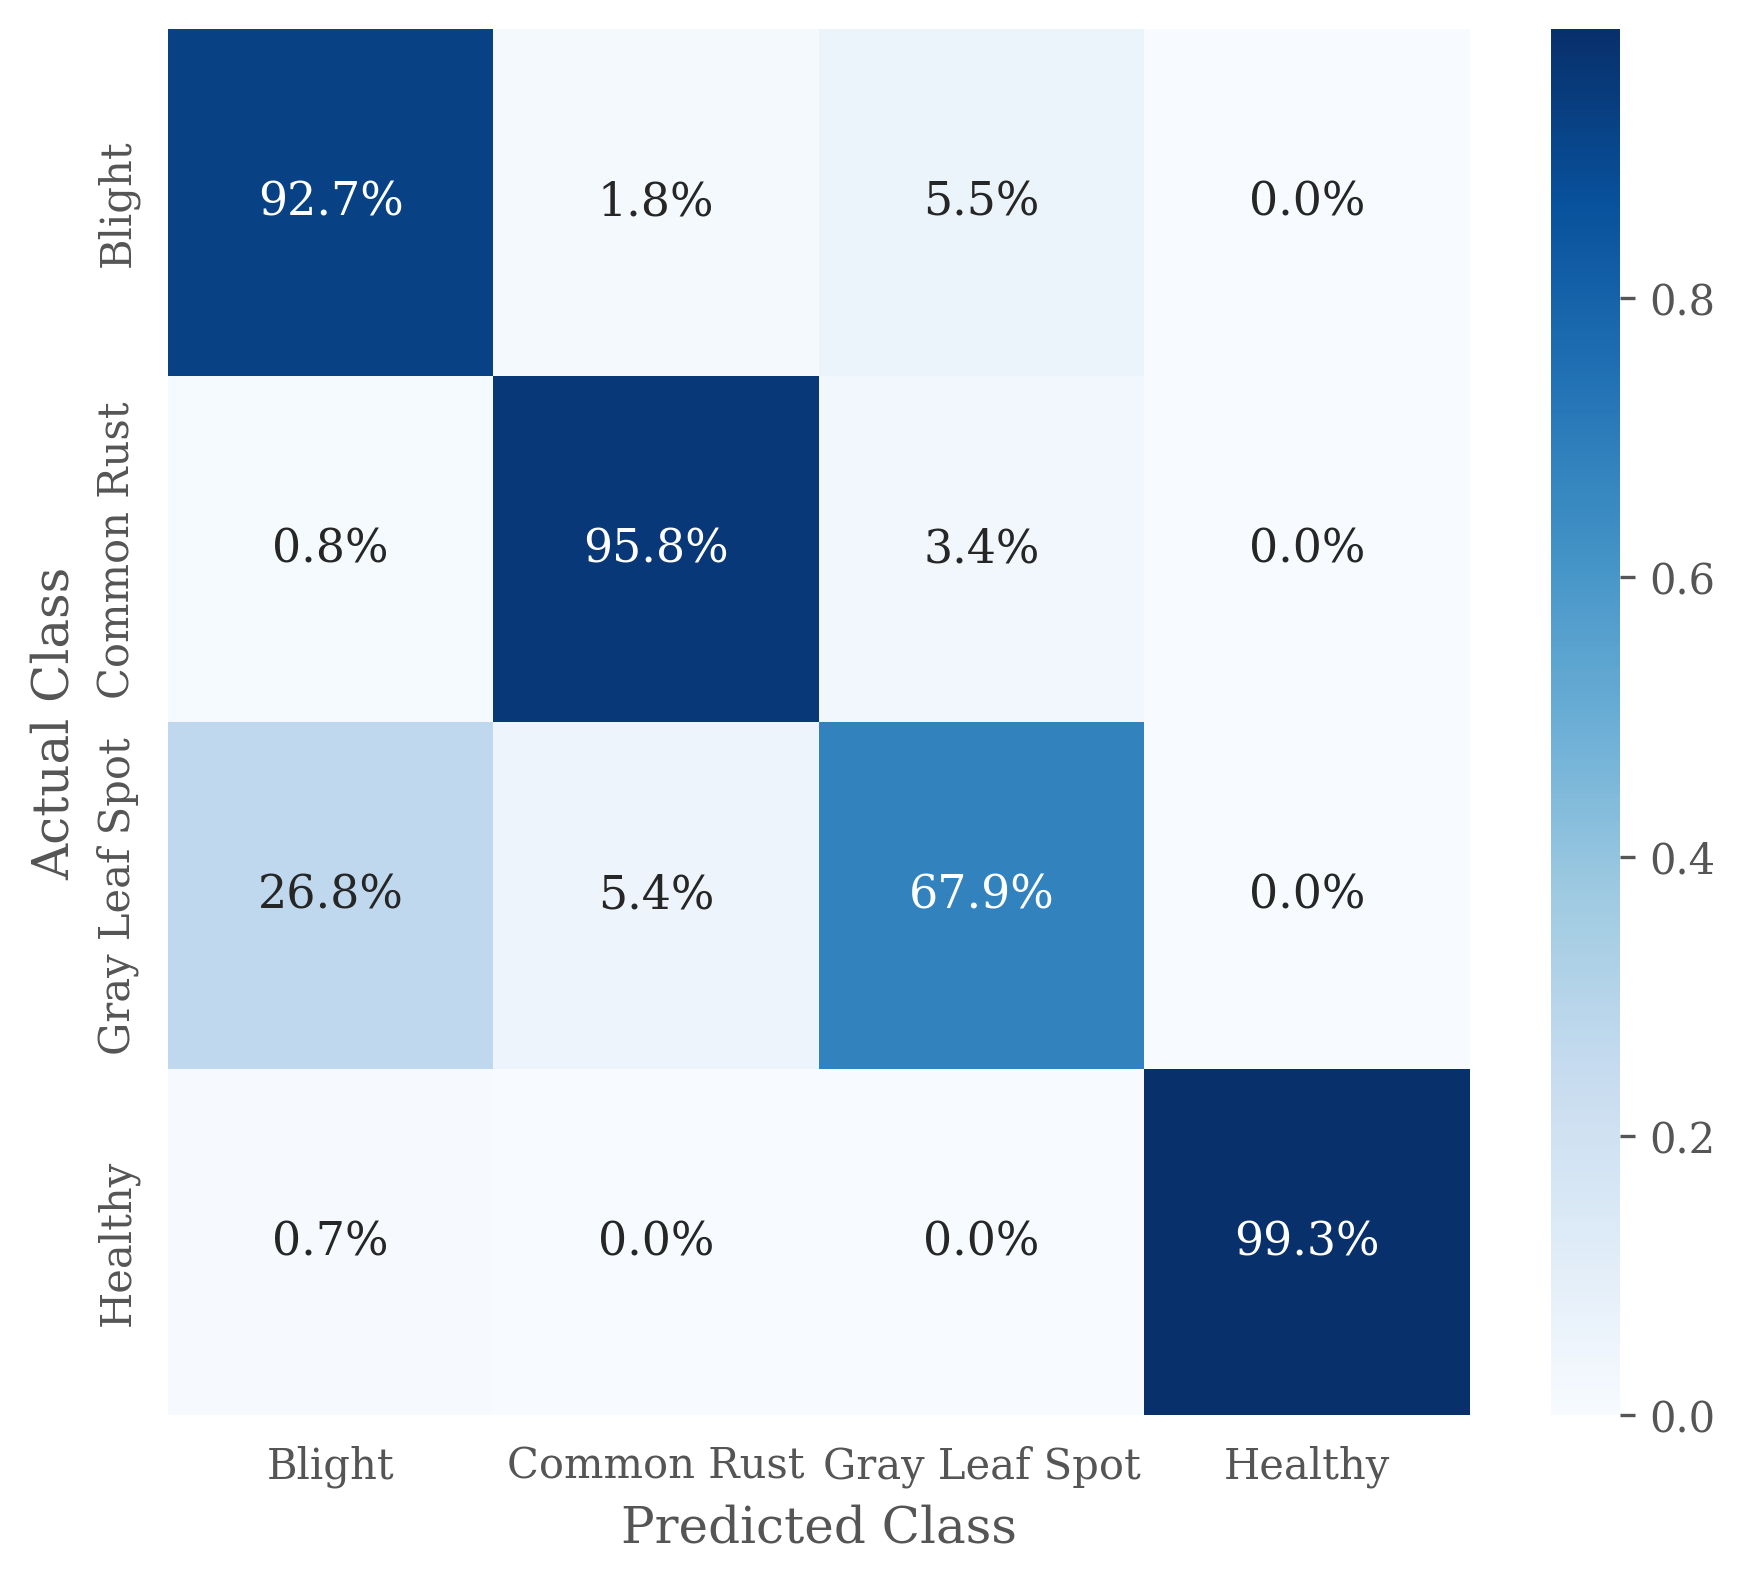

In [69]:
best_lr = tune_hyperparameter(
    lr,
    {
        'tol': [1e-5, 1e-8, 1e-4],
        'C': [0.01, 0.1, 1],
        'max_iter': [1000, 2000, 3000]
    },
    lr_X[0], lr_X[1], lr_X[2]
)

In [70]:
svc = SVC(random_state=42)
svc_X = feature_selection(svc)

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Fitting 1 folds for each of 5 candidates, totalling 5 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
2024/07/11 22:40:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2024/07/11 22:40:16 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.14.2/models.html#set-s

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


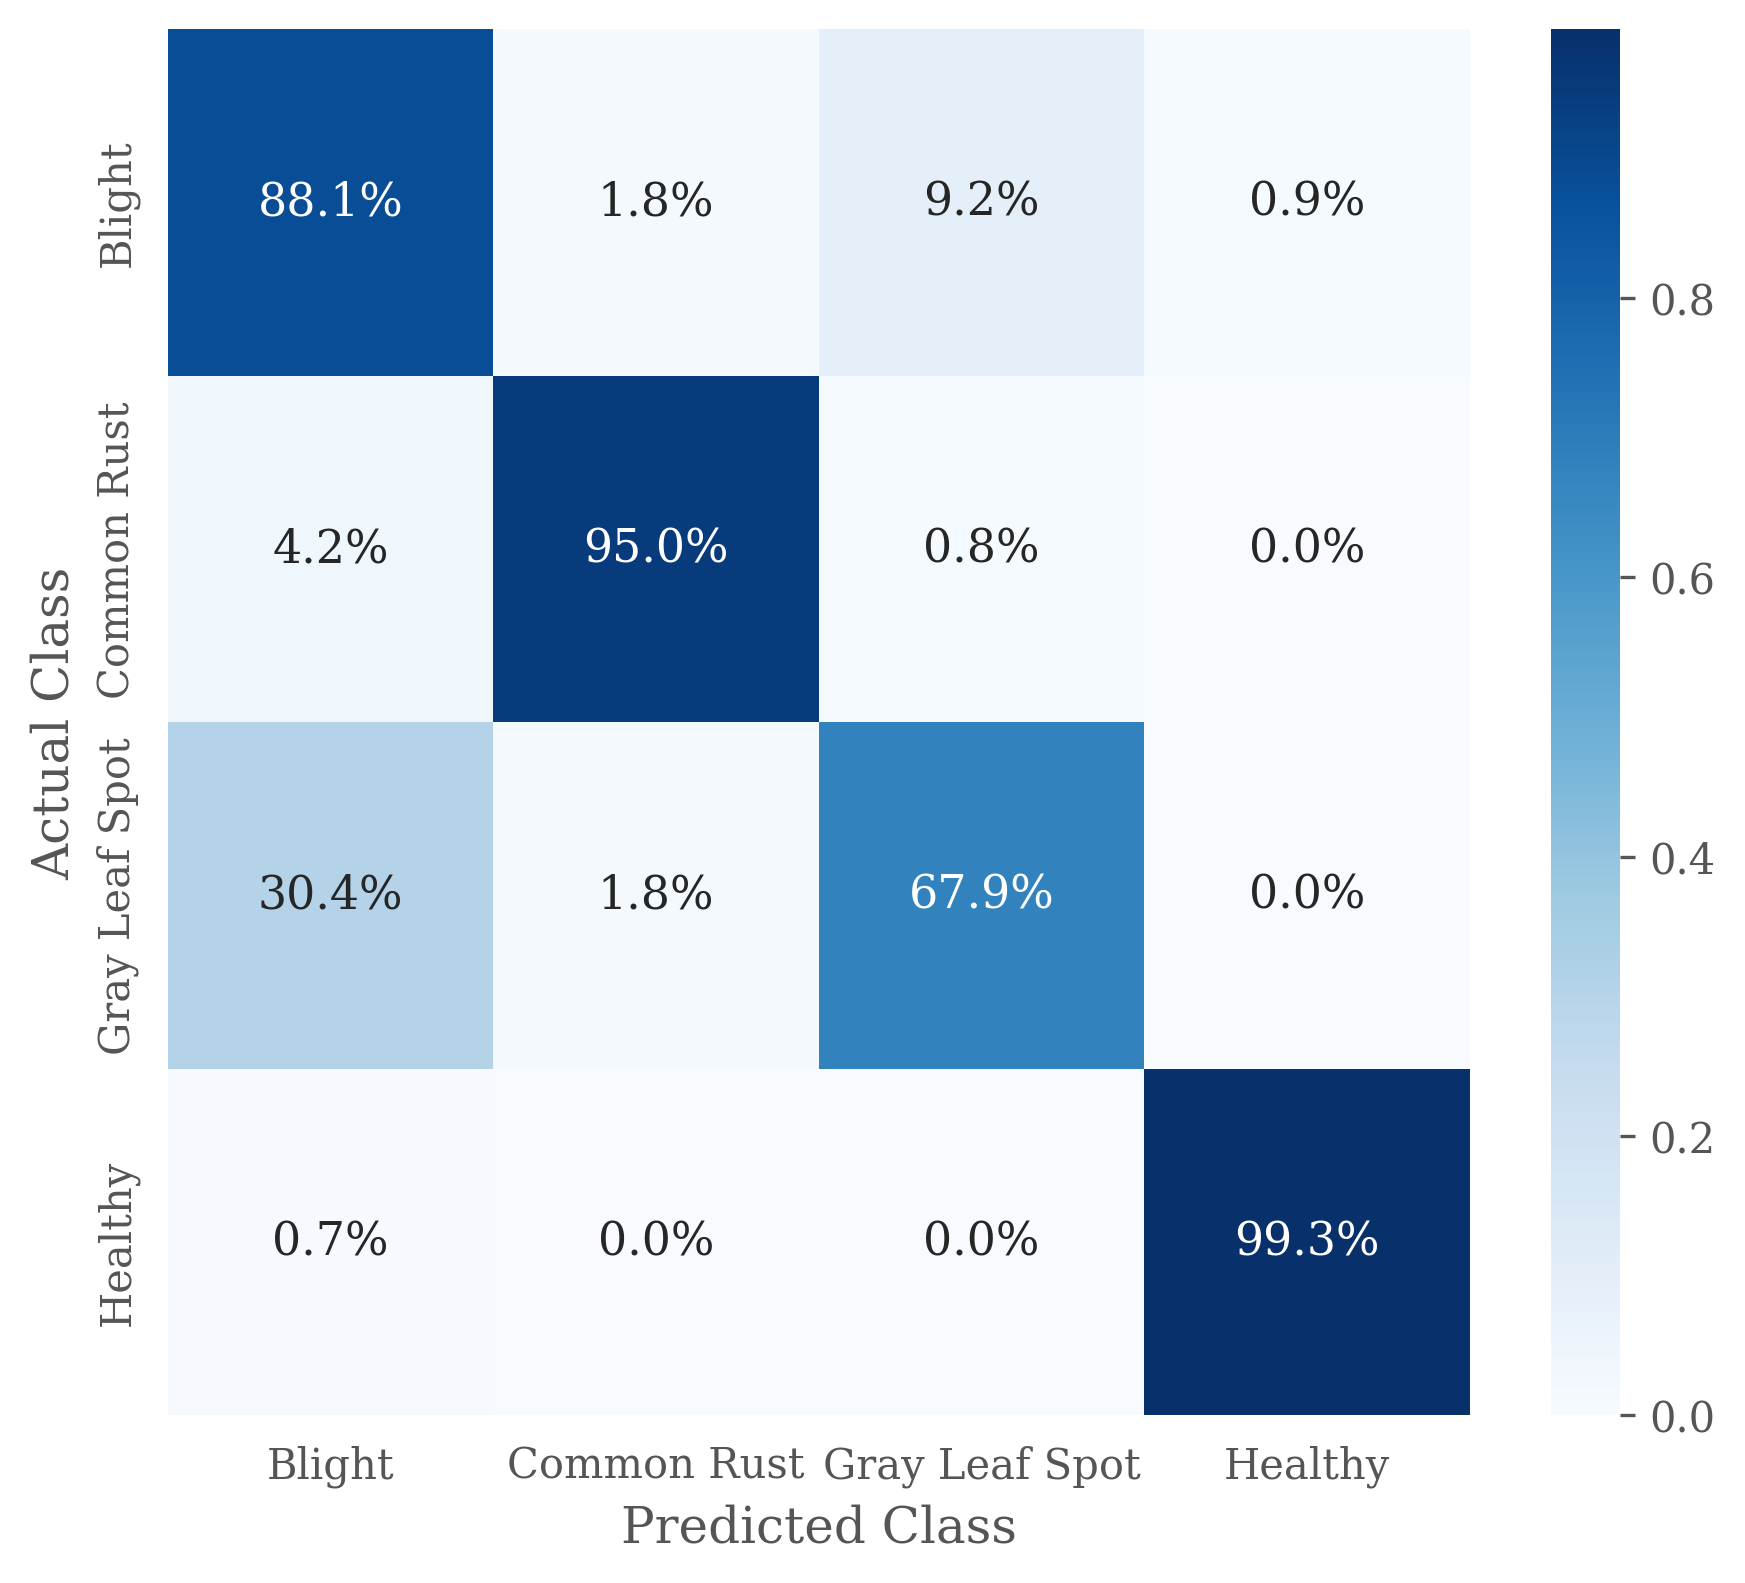

In [73]:
best_svc = tune_hyperparameter(
    svc,
    {
        'C': [1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
    },
    svc_X[0], svc_X[1], svc_X[2]
)